In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [3]:
data = sio.matlab.loadmat('../data/FlatBeam_NLResponse_RandVibe.mat')['out']
y = data[0]['def'][0].T[:, :, np.newaxis][:,10,:]
u = data[0]['fext'][0].T[:, :, np.newaxis][:,10,:]
t = data[0]['t'][0][0]

print(y.shape, u.shape, t.shape)

(10001, 1) (10001, 1) (10001,)


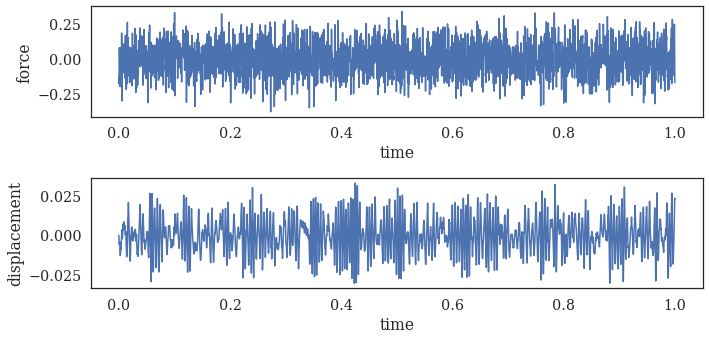

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('displacement')

plt.tight_layout()
plt.show()

5000


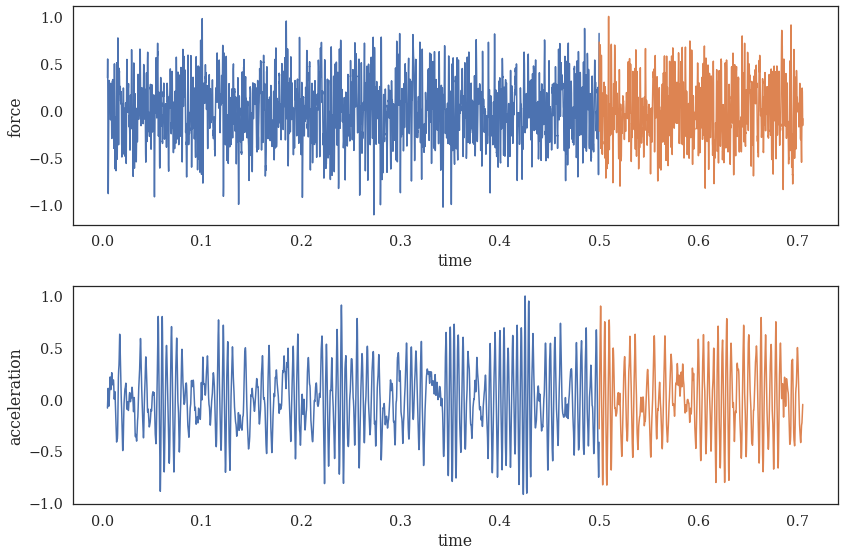

In [5]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.5)
start = 50

print(ntrain)
utrain = u_norm[start:ntrain]
ytrain = y_norm[start:ntrain]
ttrain = t[start:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:start+ntrain+2000]
ytest = y_norm[ntrain:start+ntrain+2000]
ttest = t[ntrain:start+ntrain+2000]
intest = np.hstack([utest,ytest])

ufull = np.concatenate([utrain, utest], axis = 0)
yfull = np.concatenate([ytrain, ytest], axis = 0)
infull = np.concatenate([intrain, intest], axis = 0)

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [6]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        xy = input_data[i:(i+tw), 1]
        xu = input_data[i+1:(i+tw)+1, 0]
        x = np.vstack([xu,xy])
        y = output_data[i+tw]

        xs.append(x)
        ys.append(y)

    return np.transpose(np.array(xs),[0,1,2]), np.array(ys)

In [7]:
train_window = 24

x_train, y_train = create_inout_sequences(intrain, ytrain, train_window)
x_val, y_val = create_inout_sequences(intest, ytest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

x_full, y_full = create_inout_sequences(infull, yfull, train_window)

x_full = torch.from_numpy(x_full).float()
y_full = torch.from_numpy(y_full).float()

print(x_full.shape, y_full.shape)

torch.Size([4925, 2, 24]) torch.Size([4925, 1])
torch.Size([6975, 2, 24]) torch.Size([6975, 1])


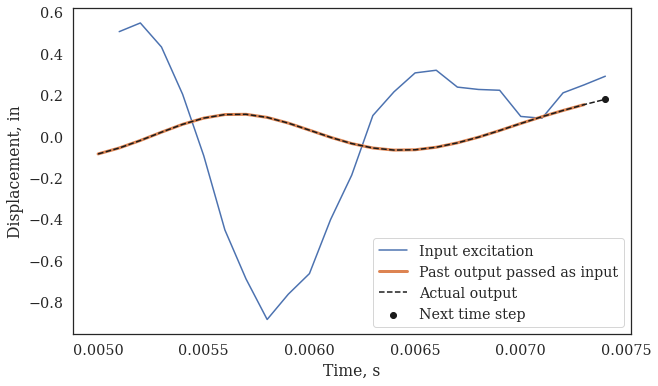

<Figure size 432x288 with 0 Axes>

In [8]:
plt.figure(figsize=(10,6))
plt.plot(ttrain[1:train_window+1], x_train[0,0,:])
plt.plot(ttrain[:train_window], x_train[0,1,:], linewidth = 3)
plt.scatter(ttrain[train_window], y_train[0], color = 'k')
plt.plot(ttrain[:train_window + 1], ytrain[:train_window + 1], 'k--')
plt.legend(['Input excitation', 'Past output passed as input', 
           'Actual output', 'Next time step'], loc = 'best')
plt.xlabel('Time, s')
plt.ylabel('Displacement, in')
plt.show()
plt.savefig('./../images/input_output.tiff')

In [9]:
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [10]:
import torch.nn.functional as F


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, seq_len, dropout):
        super(TCN, self).__init__()
        self.seq_len = seq_len
        self.num_channels = num_channels
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1]*seq_len, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        # x needs to have dimension (N, C, L) in order to be passed into CNN
        output = self.tcn(x).transpose(1, 2).reshape((-1, self.seq_len*self.num_channels[-1]))
        output = self.linear(output).double()
        return output

In [11]:
model = TCN(input_size = 2, 
            output_size = 1, 
            num_channels = [6]*6, 
            kernel_size = 3, 
            seq_len = train_window, 
            dropout = 0.1)

In [12]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction = "sum")

def train(model,epoch, X_train, Y_train, batch_size):
    global lr
    model.train()
    batch_idx = 1
    total_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        if i + batch_size > X_train.size(0):
            x, y = X_train[i:, :, :], Y_train[i:]
        else:
            x, y = X_train[i:(i+batch_size), :, :], Y_train[i:(i+batch_size)]
        optimizer.zero_grad()
        output = model(x)

        loss = F.mse_loss(output, y.double())

        loss.backward()

        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()

        if batch_idx % 25 == 0:
            cur_loss = total_loss / 25
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d} ({:.0f}%)]\tLearning rate: {:.4f}\tLoss: {:.6f}'.format(
                epoch, processed, X_train.size(0), 100.*processed/X_train.size(0), lr, cur_loss))
            total_loss = 0


def evaluate(model, X_test, Y_test):
    #model.eval()
    with torch.no_grad():
        output = model(X_test)
        test_loss = F.mse_loss(output, Y_test)
        print('\nTest set: Average loss: {:.6f}\n'.format(test_loss.item()))
        return test_loss.item()

In [13]:
epochs = 50000
batch_size = 250

for ep in range(1, epochs+1):
    train(model, ep, x_train, y_train, batch_size)
    print('Epoch: {}'.format(ep))
    tloss = evaluate(model, x_val, y_val)


Epoch: 1

Test set: Average loss: 0.115938

Epoch: 2

Test set: Average loss: 0.115653

Epoch: 3

Test set: Average loss: 0.113617

Epoch: 4

Test set: Average loss: 0.113743

Epoch: 5

Test set: Average loss: 0.113245

Epoch: 6

Test set: Average loss: 0.112229

Epoch: 7

Test set: Average loss: 0.111524

Epoch: 8

Test set: Average loss: 0.108969

Epoch: 9

Test set: Average loss: 0.108119

Epoch: 10

Test set: Average loss: 0.107816

Epoch: 11

Test set: Average loss: 0.106201

Epoch: 12

Test set: Average loss: 0.103728

Epoch: 13

Test set: Average loss: 0.101901

Epoch: 14

Test set: Average loss: 0.099637

Epoch: 15

Test set: Average loss: 0.096662

Epoch: 16

Test set: Average loss: 0.094626

Epoch: 17

Test set: Average loss: 0.091469

Epoch: 18

Test set: Average loss: 0.086482

Epoch: 19

Test set: Average loss: 0.083044

Epoch: 20

Test set: Average loss: 0.077359

Epoch: 21

Test set: Average loss: 0.071595

Epoch: 22

Test set: Average loss: 0.066341

Epoch: 23

Test set

Epoch: 182

Test set: Average loss: 0.006655

Epoch: 183

Test set: Average loss: 0.006304

Epoch: 184

Test set: Average loss: 0.006025

Epoch: 185

Test set: Average loss: 0.006080

Epoch: 186

Test set: Average loss: 0.006013

Epoch: 187

Test set: Average loss: 0.006293

Epoch: 188

Test set: Average loss: 0.005982

Epoch: 189

Test set: Average loss: 0.005767

Epoch: 190

Test set: Average loss: 0.006049

Epoch: 191

Test set: Average loss: 0.005814

Epoch: 192

Test set: Average loss: 0.005760

Epoch: 193

Test set: Average loss: 0.005653

Epoch: 194

Test set: Average loss: 0.005848

Epoch: 195

Test set: Average loss: 0.005703

Epoch: 196

Test set: Average loss: 0.005937

Epoch: 197

Test set: Average loss: 0.005662

Epoch: 198

Test set: Average loss: 0.005550

Epoch: 199

Test set: Average loss: 0.005907

Epoch: 200

Test set: Average loss: 0.005445

Epoch: 201

Test set: Average loss: 0.005422

Epoch: 202

Test set: Average loss: 0.005821

Epoch: 203

Test set: Average loss


Test set: Average loss: 0.002241

Epoch: 361

Test set: Average loss: 0.002097

Epoch: 362

Test set: Average loss: 0.002160

Epoch: 363

Test set: Average loss: 0.002220

Epoch: 364

Test set: Average loss: 0.002259

Epoch: 365

Test set: Average loss: 0.002246

Epoch: 366

Test set: Average loss: 0.002164

Epoch: 367

Test set: Average loss: 0.002182

Epoch: 368

Test set: Average loss: 0.002060

Epoch: 369

Test set: Average loss: 0.002074

Epoch: 370

Test set: Average loss: 0.002151

Epoch: 371

Test set: Average loss: 0.002061

Epoch: 372

Test set: Average loss: 0.002092

Epoch: 373

Test set: Average loss: 0.002155

Epoch: 374

Test set: Average loss: 0.002052

Epoch: 375

Test set: Average loss: 0.001992

Epoch: 376

Test set: Average loss: 0.002062

Epoch: 377

Test set: Average loss: 0.002084

Epoch: 378

Test set: Average loss: 0.001928

Epoch: 379

Test set: Average loss: 0.001994

Epoch: 380

Test set: Average loss: 0.001943

Epoch: 381

Test set: Average loss: 0.001960


Epoch: 539

Test set: Average loss: 0.000975

Epoch: 540

Test set: Average loss: 0.000925

Epoch: 541

Test set: Average loss: 0.000967

Epoch: 542

Test set: Average loss: 0.000955

Epoch: 543

Test set: Average loss: 0.000929

Epoch: 544

Test set: Average loss: 0.000941

Epoch: 545

Test set: Average loss: 0.000882

Epoch: 546

Test set: Average loss: 0.000918

Epoch: 547

Test set: Average loss: 0.000927

Epoch: 548

Test set: Average loss: 0.000913

Epoch: 549

Test set: Average loss: 0.000951

Epoch: 550

Test set: Average loss: 0.000895

Epoch: 551

Test set: Average loss: 0.000868

Epoch: 552

Test set: Average loss: 0.000904

Epoch: 553

Test set: Average loss: 0.000950

Epoch: 554

Test set: Average loss: 0.000934

Epoch: 555

Test set: Average loss: 0.000873

Epoch: 556

Test set: Average loss: 0.000890

Epoch: 557

Test set: Average loss: 0.000857

Epoch: 558

Test set: Average loss: 0.000897

Epoch: 559

Test set: Average loss: 0.000863

Epoch: 560

Test set: Average loss


Test set: Average loss: 0.000462

Epoch: 718

Test set: Average loss: 0.000478

Epoch: 719

Test set: Average loss: 0.000472

Epoch: 720

Test set: Average loss: 0.000480

Epoch: 721

Test set: Average loss: 0.000488

Epoch: 722

Test set: Average loss: 0.000473

Epoch: 723

Test set: Average loss: 0.000472

Epoch: 724

Test set: Average loss: 0.000457

Epoch: 725

Test set: Average loss: 0.000464

Epoch: 726

Test set: Average loss: 0.000471

Epoch: 727

Test set: Average loss: 0.000448

Epoch: 728

Test set: Average loss: 0.000464

Epoch: 729

Test set: Average loss: 0.000437

Epoch: 730

Test set: Average loss: 0.000455

Epoch: 731

Test set: Average loss: 0.000456

Epoch: 732

Test set: Average loss: 0.000448

Epoch: 733

Test set: Average loss: 0.000459

Epoch: 734

Test set: Average loss: 0.000456

Epoch: 735

Test set: Average loss: 0.000447

Epoch: 736

Test set: Average loss: 0.000437

Epoch: 737

Test set: Average loss: 0.000468

Epoch: 738

Test set: Average loss: 0.000464


Epoch: 896

Test set: Average loss: 0.000315

Epoch: 897

Test set: Average loss: 0.000301

Epoch: 898

Test set: Average loss: 0.000315

Epoch: 899

Test set: Average loss: 0.000302

Epoch: 900

Test set: Average loss: 0.000314

Epoch: 901

Test set: Average loss: 0.000293

Epoch: 902

Test set: Average loss: 0.000304

Epoch: 903

Test set: Average loss: 0.000300

Epoch: 904

Test set: Average loss: 0.000301

Epoch: 905

Test set: Average loss: 0.000283

Epoch: 906

Test set: Average loss: 0.000286

Epoch: 907

Test set: Average loss: 0.000289

Epoch: 908

Test set: Average loss: 0.000284

Epoch: 909

Test set: Average loss: 0.000280

Epoch: 910

Test set: Average loss: 0.000293

Epoch: 911

Test set: Average loss: 0.000294

Epoch: 912

Test set: Average loss: 0.000295

Epoch: 913

Test set: Average loss: 0.000290

Epoch: 914

Test set: Average loss: 0.000296

Epoch: 915

Test set: Average loss: 0.000289

Epoch: 916

Test set: Average loss: 0.000287

Epoch: 917

Test set: Average loss

Epoch: 1073

Test set: Average loss: 0.000201

Epoch: 1074

Test set: Average loss: 0.000204

Epoch: 1075

Test set: Average loss: 0.000200

Epoch: 1076

Test set: Average loss: 0.000205

Epoch: 1077

Test set: Average loss: 0.000204

Epoch: 1078

Test set: Average loss: 0.000217

Epoch: 1079

Test set: Average loss: 0.000195

Epoch: 1080

Test set: Average loss: 0.000198

Epoch: 1081

Test set: Average loss: 0.000218

Epoch: 1082

Test set: Average loss: 0.000200

Epoch: 1083

Test set: Average loss: 0.000195

Epoch: 1084

Test set: Average loss: 0.000201

Epoch: 1085

Test set: Average loss: 0.000200

Epoch: 1086

Test set: Average loss: 0.000205

Epoch: 1087

Test set: Average loss: 0.000189

Epoch: 1088

Test set: Average loss: 0.000200

Epoch: 1089

Test set: Average loss: 0.000190

Epoch: 1090

Test set: Average loss: 0.000192

Epoch: 1091

Test set: Average loss: 0.000202

Epoch: 1092

Test set: Average loss: 0.000190

Epoch: 1093

Test set: Average loss: 0.000192

Epoch: 1094



Epoch: 1248

Test set: Average loss: 0.000154

Epoch: 1249

Test set: Average loss: 0.000155

Epoch: 1250

Test set: Average loss: 0.000158

Epoch: 1251

Test set: Average loss: 0.000156

Epoch: 1252

Test set: Average loss: 0.000149

Epoch: 1253

Test set: Average loss: 0.000154

Epoch: 1254

Test set: Average loss: 0.000154

Epoch: 1255

Test set: Average loss: 0.000155

Epoch: 1256

Test set: Average loss: 0.000150

Epoch: 1257

Test set: Average loss: 0.000160

Epoch: 1258

Test set: Average loss: 0.000155

Epoch: 1259

Test set: Average loss: 0.000165

Epoch: 1260

Test set: Average loss: 0.000150

Epoch: 1261

Test set: Average loss: 0.000152

Epoch: 1262

Test set: Average loss: 0.000152

Epoch: 1263

Test set: Average loss: 0.000145

Epoch: 1264

Test set: Average loss: 0.000148

Epoch: 1265

Test set: Average loss: 0.000152

Epoch: 1266

Test set: Average loss: 0.000149

Epoch: 1267

Test set: Average loss: 0.000150

Epoch: 1268

Test set: Average loss: 0.000154

Epoch: 1269



Epoch: 1423

Test set: Average loss: 0.000127

Epoch: 1424

Test set: Average loss: 0.000127

Epoch: 1425

Test set: Average loss: 0.000126

Epoch: 1426

Test set: Average loss: 0.000132

Epoch: 1427

Test set: Average loss: 0.000124

Epoch: 1428

Test set: Average loss: 0.000126

Epoch: 1429

Test set: Average loss: 0.000126

Epoch: 1430

Test set: Average loss: 0.000126

Epoch: 1431

Test set: Average loss: 0.000124

Epoch: 1432

Test set: Average loss: 0.000128

Epoch: 1433

Test set: Average loss: 0.000131

Epoch: 1434

Test set: Average loss: 0.000124

Epoch: 1435

Test set: Average loss: 0.000130

Epoch: 1436

Test set: Average loss: 0.000127

Epoch: 1437

Test set: Average loss: 0.000132

Epoch: 1438

Test set: Average loss: 0.000126

Epoch: 1439

Test set: Average loss: 0.000127

Epoch: 1440

Test set: Average loss: 0.000127

Epoch: 1441

Test set: Average loss: 0.000126

Epoch: 1442

Test set: Average loss: 0.000125

Epoch: 1443

Test set: Average loss: 0.000129

Epoch: 1444



KeyboardInterrupt: 

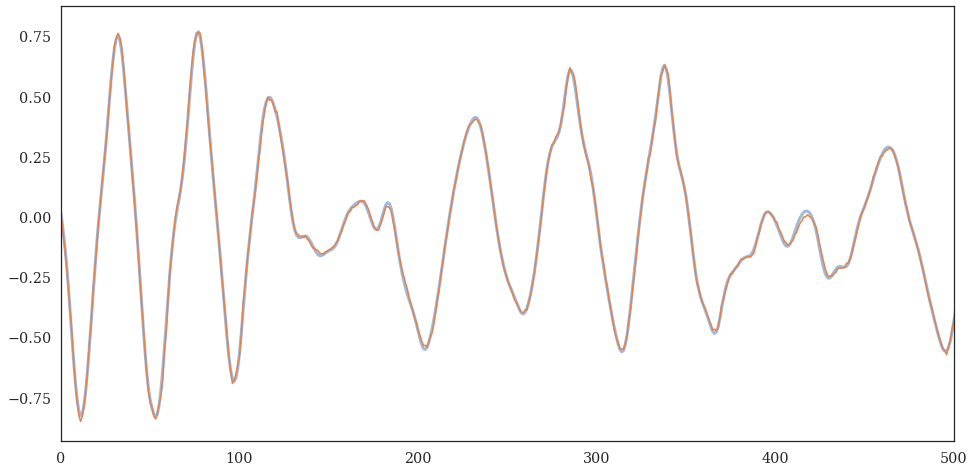

In [14]:
ypred = model(x_val)

plt.figure(figsize = (16, 8))

plt.plot(y_val, linewidth = 3, alpha = 0.5)
plt.plot(ypred.detach().numpy())

plt.xlim([0,500])
plt.show()

In [15]:

def simulate(x0, u, future):
    tw = x0.shape[-1]
    feats = x0.shape[0]

    x_ = x0.reshape((1,feats,tw))
    x = x0
    ypred = model(x_)
    
    for ii in range(1,future):
        new_pair = np.array([u[tw + ii][0], ypred.detach().numpy()[0][0]]).reshape((2,-1))
        x = np.concatenate([x, new_pair], axis = -1)
        
        x_ = x[:, -tw:].reshape((1, feats, tw))
        x_ = torch.from_numpy(x_)
        ypred = model(x_.float())
        
    return x

In [17]:
x0 = x_val[0]
ypred_sim = simulate(x0, utest, 500)
ypred_sim = ypred_sim[-1,train_window:]

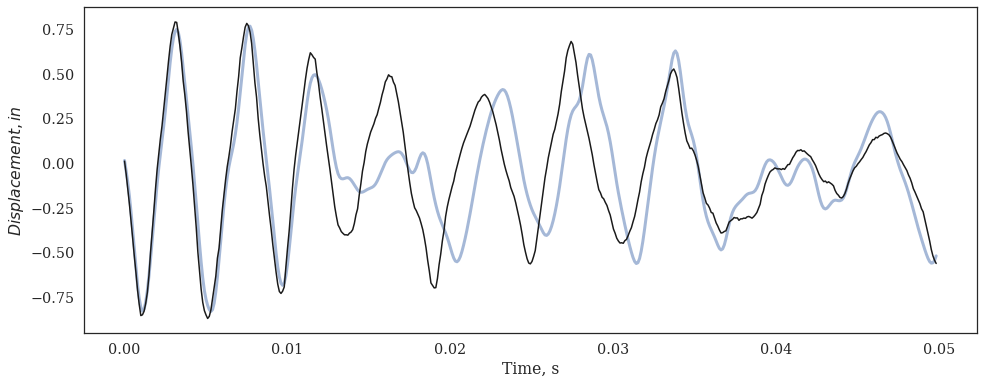

In [22]:

plt.figure(figsize = (16, 6))

plt.plot(t[:500-1], y_val[:500-1], linewidth = 3, alpha = 0.5)
plt.plot(t[:500-1], ypred_sim.T, 'k')

plt.ylabel('$Displacement, in$')
plt.xlabel('Time, s')

#plt.xlim([0,500])
plt.show()

In [68]:
utest.shape
u_norm.shape

(10001, 1)

In [23]:
x0 = x_full[0]
npred = x_full.shape[0] - 1
ypred_sim = simulate(x0, ufull, npred)
ypred_sim = ypred_sim[-1,train_window:]

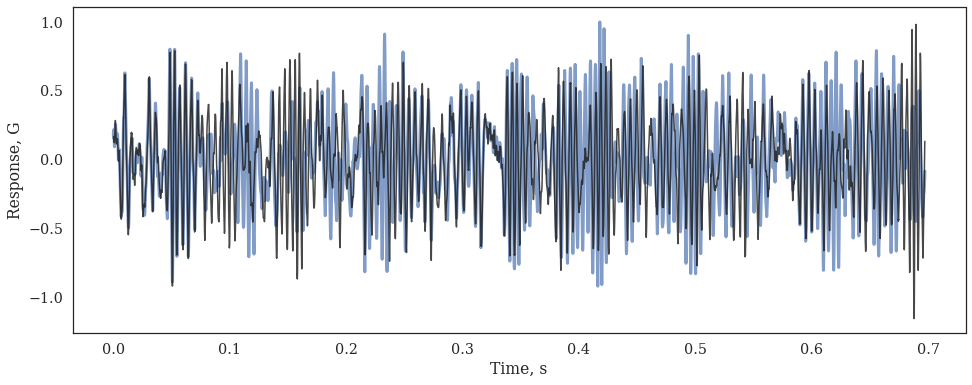

In [29]:
plt.figure(figsize = (16, 6))

plt.plot(t[:npred], yfull[train_window:-2], linewidth = 3, alpha = 0.7)
plt.plot(t[:npred-1], ypred_sim.T, 'k', alpha = 0.8)

plt.ylabel('Response, G')
plt.xlabel('Time, s')

#plt.xlim([0,npred])
plt.show()

In [43]:
mse = np.sum((yfull[train_window:-3].reshape((-1,)) - ypred_sim)**2)/len(yfull[train_window:-3])
print(mse)

0.11858126424471976


In [37]:
yfull[train_window:-1].shape

(6975, 1)

In [104]:
nchannels = [3, 6, 9]
nlayers = [3, 5, 7]
kernelsize = [3]

epochs = 500
batch_size = 250

hyperparams = []

for nc in nchannels:
    for nl in nlayers:
        for ks in kernelsize:
            model = TCN(input_size = 2, 
                        output_size = 1, 
                        num_channels = [nc]*nl, 
                        kernel_size = ks, 
                        seq_len = train_window, 
                        dropout = 0.1)
            print([nc]*nl)
            for ep in range(1, epochs+1):
                train(model, ep, x_train, y_train, batch_size)
                if ep % 50 == 0:
                    print('Epoch: {}'.format(ep))
                    tloss = evaluate(model, x_val, y_val)
            
            hyperparams.append([nc, nl, ks, tloss])
            print(hyperparams[-1])
            
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))


[3, 3, 3]
Epoch: 50

Test set: Average loss: 1.173970

Epoch: 100

Test set: Average loss: 1.164860

Epoch: 150

Test set: Average loss: 1.174647

Epoch: 200

Test set: Average loss: 1.169710

Epoch: 250

Test set: Average loss: 1.175539

Epoch: 300

Test set: Average loss: 1.177534

Epoch: 350

Test set: Average loss: 1.175668

Epoch: 400

Test set: Average loss: 1.165821

Epoch: 450

Test set: Average loss: 1.174930

Epoch: 500

Test set: Average loss: 1.190137

[3, 3, 3, 1.1901369514374631]
[3, 3, 3, 3, 3]
Epoch: 50

Test set: Average loss: 0.244408

Epoch: 100

Test set: Average loss: 0.248154

Epoch: 150

Test set: Average loss: 0.246772

Epoch: 200

Test set: Average loss: 0.248602

Epoch: 250

Test set: Average loss: 0.248202

Epoch: 300

Test set: Average loss: 0.240986

Epoch: 350

Test set: Average loss: 0.247317

Epoch: 400

Test set: Average loss: 0.244650

Epoch: 450

Test set: Average loss: 0.244559

Epoch: 500

Test set: Average loss: 0.245608

[3, 5, 3, 0.24560780395239

NameError: name 'pickle' is not defined

In [105]:
import pickle 
pickle.dump(hyperparams, open('hyperparam_runs.pickle', 'wb'))

In [106]:
hyperparams

[[3, 3, 3, 1.1901369514374631],
 [3, 5, 3, 0.2456078039523973],
 [3, 7, 3, 0.5105965993993377],
 [6, 3, 3, 0.11973414125472952],
 [6, 5, 3, 0.5458264064765384],
 [6, 7, 3, 0.20835276448076956],
 [9, 3, 3, 0.14021653580262358],
 [9, 5, 3, 0.27441562471524916],
 [9, 7, 3, 0.13629748571598935]]

In [109]:
from statsmodels.tsa.arima_model import ARMA

ModuleNotFoundError: No module named 'statsmodels'